# GLayout: Automtization of the design path

```
OpenFASOC Team, September 2024
SPDX-License-Identifier: Apache-2.0
```

|Name|Affiliation| IEEE Member | SSCS Member |
|:-----------------:|:----------:|:----------:|:----------:|
| Eva Deltor | Institute of Microelectronics of Barcelona (IMB-CNM-CSIC) - UAB               | No  | No  |

## Introduction
GLayout is a technology-independent analog layout generator that allows users to seamlessly transition a design from one process design kit (PDK) technology to another without the need to redo the entire layout. It simplifies the layout creation process, as parameters like width and length can be easily modified, and the design updates automatically.

However, the designer must perform an initial iteration, which includes defining the floorplan, setting limits, checking rules, and making connections, among other tasks. The purpose of this notebook is to reduce that workload. The goal is that once the designer has completed the schematic tests, they can import the .sch and .spice files into this code and receive the .gds file in return, regardless of the type of circuit, the number of transistors or connections.

However, since this is just an initial proof of concept, I've acknowledged a few limitations. The biggest one is related to area optimization. From the designs shown during the SSCS'25 course, it's clear that the area wasn't optimized (example below), so I've kept it simple for now. Optimizing the area would require a more complex algorithm, which should be tackled in future updates.

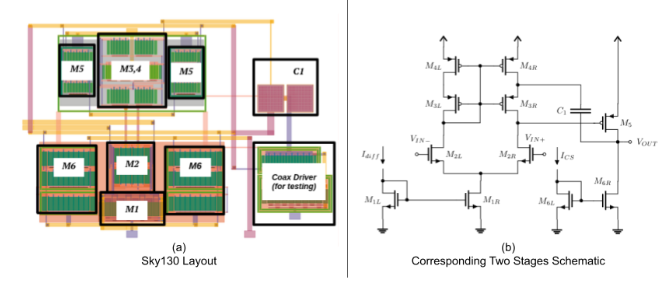

The procedure for transitioning from schematic design to layout involves two main steps:

1. Extract positions from the .sch file: The schematic's positions are extracted, and the transistors are placed in a similar manner to the schematic design. This method was chosen because, in my experience, the layout often mirrors the schematic structure. These positions are then sent to the algorithm to place the transistors in the floorplan. One advantage of this approach is that if the designer wants to position the layout in a specific way, they only need to define it in the schematic design. This file has this structure:
```
	C {ipin.sym} 840 210 0 1 {name=p1 lab=VIN+}
	C {ipin.sym} 540 210 0 0 {name=p2 lab=VIN-}
	C {opin.sym} 970 200 0 0 {name=p3 lab=VOUT}
	C {pmos3.sym} 950 -30 0 0 {name=X2 model=irf5305}
	C {pmos3.sym} 950 70 0 0 {name=X4 model=irf5305}
	C {pmos3.sym} 390 -30 0 1 {name=X6 model=irf5305 w=1u l = 1u}
	C {pmos3.sym} 390 70 0 1 {name=X8 model=irf5305}
	C {pmos3.sym} 820 210 0 1 {name=X9 model=irf5305}
```
2. Extract connectivity from the .spice file: The .spice file helps determine the connections for each transistor pin. A graph has been created to retrieve this information due to its ease of accessing connections and interpreting results. Initially, the plan was to hard code multiple functions to achieve this, but the graph representation proved to be much more powerful. The algorithm uses the graph to retrieve wire connections between transistors. This file has this structure:   
```
    X2 net13 net12 VDD irf5305
    X4 VOUT net11 net13 irf5305
    X6 net12 net12 VDD irf5305
    X8 net11 net11 net12 irf5305
    X9 net8 VIN+ IBIAS irf5305
    X10 net9 VIN- IBIAS irf5305
    X11 VOUT net8 net7 irf540 m=1
```



All in all, the pipeline can be summarized as follows:
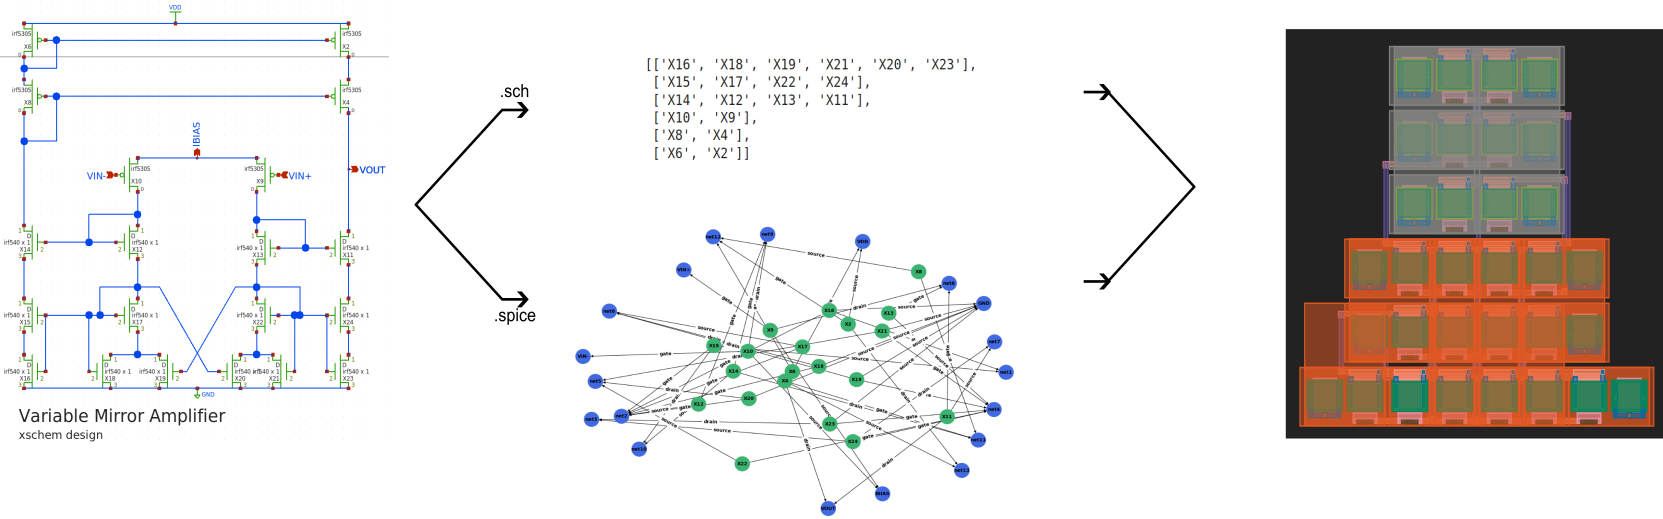

This project design started with the Miyahara circuit, as it was the chosen circuit for the SSCS'24 Chipathon. Once it was designed, I wanted to see if it could be generalized with the Fifty Nifty Paper circuits presented in the lectures, so you will find some of these designs in the folder as well. Since that worked, I didn't want to miss the opportunity to check other complex circuits like the Variable Mirror Amplifier (VMA). If you have your own design, please don't hesitate to test it!

So, in the following notebook I will explain the steps followed in order to obtain the layout with **(practically) any** design that can come to your minds!

The notebook is structured as follows:

1. **State of the art of automatic analog design**: Discusses how this notebook represents a step forward in open-source automatic analog design.

2. **Environment setup:** Includes several lines of code to prepare the environment. I designed everything in the Google Colab Notebook due to issues with installing the libraries on my PC. Despite this initial problem, using Google Colab demonstrates the powerful capabilities of the library and simplifies sharing between users, as it makes running the notebook locally more challenging.

3. **Manual design of the Miyahara circuit:** Provides a detailed look at the complexity of Python design for someone new in the field.

4. **Supporting functions:** Contains a series of functions used by the algorithm. These functions transform the input .sch and .spice files into useful information for the algorithm. I decided to hide them to keep the notebook organized, but feel free to open them and check the code!

5. **Algorithm functions for layout creation:** This section includes the functions that make up the algorithm dedicated to creating the layout. You will see up to eight versions, which I kept to show the mental process followed in the design and for educational purposes in layout design (I am not an expert in this field, so there is definitely room for improvement).

*Disclaimer: This project has been developed in just one month, therefore it is just the begining of a concept that seems promising. The tests that were carried have been just a small sample of what electronics is nowadays, for that reason there might be situations in which our functions don't operate as good as they should. Improvement needs to be done in order to make it generalizable.*

# 1. State of the art
Some papers have explored the automatic design of circuits. One of the first proposals was made in [1], where they designed parametrized generators based on input specifications. Later, in [2], the open-source community began to make strides thanks to Google's leadership and how the tools used in this project started to play a role in EDA design. This concept was applied in [3] as a temperature sensor generator in SkyWater 130 nm. Recently, in [4], the design process advanced further, allowing human commands to be written in text, which the algorithm could understand and use to create the layout.

Based on this recent development, and recognizing its impressive contribution, my experience as junior designer suggests that explaining the design needs to an AI in analog design is not always comfortable. We find a more engineer-oriented approach—using schematics and a table of specifications—makes, makes me feel more at ease and simplifies the design process enabling me more control of what I am actually doing.


References:


 [1] https://ieeexplore.ieee.org/document/8357061/

 [2] https://ieeexplore.ieee.org/document/9256818

 [3] https://ieeexplore.ieee.org/document/9816083

 [4] https://www.researchgate.net/publication/383875082_Human_Language_to_Analog_Layout_Using_GLayout_Layout_Automation_Framework


# 2. Prepare the environment

In [92]:
#@title Setup the environment for the OpenFASOC GDSFactory generator
# You only need to run this block once!

# Clone OpenFASoC
!git clone https://github.com/idea-fasoc/OpenFASOC
# Install python dependencies
!pip install sky130
!pip install gf180 prettyprinttree svgutils
!pip install gdsfactory==7.7.0

import pathlib
import os
# Install KLayout (via conda)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}

!bin/micromamba create --yes --prefix $CONDA_PREFIX
# Install from the litex-hub channel
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        klayout

Cloning into 'OpenFASOC'...
remote: Enumerating objects: 16501, done.
remote: Counting objects: 100% (3752/3752), done.
remote: Compressing objects: 100% (551/551), done.
remote: Total 16501 (delta 3320), reused 3409 (delta 3196), pack-reused 12749 (from 1)
Receiving objects: 100% (16501/16501), 410.32 MiB | 16.27 MiB/s, done.
Resolving deltas: 100% (10102/10102), done.
Updating files: 100% (1849/1849), done.
  Using cached gdsfactory-8.5.6-py3-none-any.whl.metadata (11 kB)
  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached kfactory-0.18.4-py3-none-any.whl.metadata (4.4 kB)
  Using cached trimesh-4.4.9-py3-none-any.whl.metadata (18 kB)
  Using cached pydantic_core-2.20.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
Using cached gdsfactory-8.5.6-py3-none-any.whl (631 kB)
Using cached kfactory-0.18.4-py3-none-any.whl (147 kB)
Using cached pydantic-2.8.2-py3-none-any.whl (423 kB)
Using cached pydantic_core-2.20.1-cp310-cp310-man

In [93]:
#@title Setup the environment for the OpenFASOC GDSFactory generator II
# Adding micro-mamba binary directory to the PATH
# This directory contains Klayout
import pathlib
import os
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}
# Add conda packages to the PATH
PATH = os.environ['PATH']
%env PATH={PATH}:{CONDA_PREFIX}/bin

%cd /content/OpenFASOC/openfasoc/generators/glayout

env: CONDA_PREFIX=/content/OpenFASOC/openfasoc/generators/glayout/conda-env
env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/conda-env/bin:/content/OpenFASOC/openfasoc/generators/glayout/conda-env/bin
/content/OpenFASOC/openfasoc/generators/glayout


In [199]:
#@title Imports
from gdsfactory import Component
from glayout.flow.pdk.mappedpdk import MappedPDK
from glayout.flow.placement.two_transistor_interdigitized import two_nfet_interdigitized,two_pfet_interdigitized
from glayout.flow.pdk.util.comp_utils import prec_ref_center, movey, movex, evaluate_bbox
from glayout.flow.routing.smart_route import smart_route, c_route

from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk

from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk as sky130
from glayout.flow.pdk.gf180_mapped  import gf180_mapped_pdk  as gf180
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets
from glayout.flow.primitives.via_gen import via_stack
from gdsfactory.components import rectangle
import numpy as np

In [95]:
#@title Functions ONLY for GoogleColab

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)

#  3. Manual design
Let's start first seeing how we would design the Miyahara comparator manually. It is important to have this starting point in order to see that eventhough in the long term is an automatic process, because we can change the width, lenght, the pdk (!the most important)... the first design is basically hard coding. With that example will see how the project presented in this Notebook adds value to the existing state of the art.

From the main block we can distinguish a basic structure from which we can build the circuit. A pair of transistors is the most basic concept we can observe. We don't want to talk about a differential pair because we can see three configurations.


*   Differential Pair
*   NMOS - NMOS Pair
*   PMOS - NMOS Pair

So the concept is to build a piece of code able to create this diffrent configurations and based on that add the other transistors with which we will be able to build the Miyahara comparator.
Also with this building process it will be easier to build other comparators with such a few time.

From the image below we can distinguish four stages/levels of code:


*   1rst purple: basic block of a pair of transistors each with diferent selectable properties
*   2nd green: to those basic blocks add some "spare" transistors which make the top and part of bottom circuit
*   3rd orange: finish builing the bottom circuit
*   4th blue: join top and bottom.
*   (not yet) 5th: build the external circuit



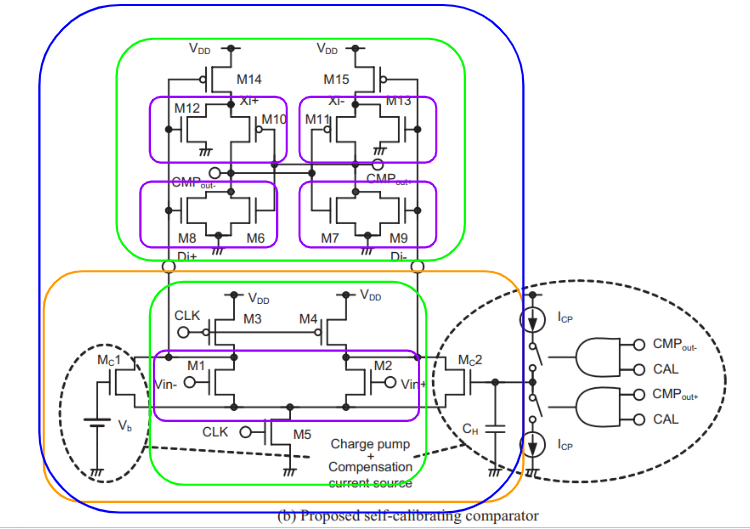



### Purple

In [ ]:
def TransistorPair(pdk: MappedPDK, type, same, width, length,portName):
    TransistorPair = Component(name="TransistorPair")

    '''
    Aquest bloc serveix com a base per al circuit, són els blocs liles
    Simplement son dos transistors connectats junts
    '''
    portNameP = portName+"_p_"
    portNameN = portName+"_n_"
    if same == True:
      if type == "PMOS":
          diffp = two_pfet_interdigitized(pdk, numcols=2, dummy=True, with_substrate_tap=False, with_tie=True, width=width, length=length, rmult=1)
          diffp_ref = prec_ref_center(diffp)
          TransistorPair.add(diffp_ref)
          TransistorPair.add_ports(diffp_ref.get_ports_list(), prefix=portNameP)
      if type == "NMOS":
          diffn = two_nfet_interdigitized(pdk, numcols=2, dummy=True, with_substrate_tap=False, with_tie=True, width=width, length=length, rmult=1)
          diffn_ref = prec_ref_center(diffn)
          TransistorPair.add(diffn_ref)
          TransistorPair.add_ports(diffn_ref.get_ports_list(), prefix=portNameN)
    else:
          diffp = two_pfet_interdigitized(pdk, numcols=2, dummy=True, with_substrate_tap=False, with_tie=True, width=width, length=length, rmult=1)
          diffn = two_nfet_interdigitized(pdk, numcols=2, dummy=True, with_substrate_tap=False, with_tie=True, width=width, length=length, rmult=1)
          diffp_ref = prec_ref_center(diffp)
          diffn_ref = prec_ref_center(diffn)
          TransistorPair.add(diffp_ref)
          TransistorPair.add(diffn_ref)

          movey(diffn_ref,-(evaluate_bbox(diffp)[1]/2+evaluate_bbox(diffn)[1]/2+pdk.util_max_metal_seperation()))
          TransistorPair.add_ports(diffp_ref.get_ports_list(), prefix=portNameP)
          TransistorPair.add_ports(diffn_ref.get_ports_list(), prefix=portNameN)
          #routing

          TransistorPair << smart_route(pdk, TransistorPair.ports[portNameP+"A_drain_E"], TransistorPair.ports[portNameN+"B_drain_E"])
          TransistorPair << smart_route(pdk, TransistorPair.ports[portNameP+"A_source_W"], TransistorPair.ports[portNameN+"B_source_W"])



    return TransistorPair

In [ ]:
# prueba_PMOS = TransistorPair(sky130_mapped_pdk, "PMOS", True, 2, 2,portName = "PMOS_PMOS")
# prueba_PMOS.write_gds('prueba_PMOS.gds')
# display_gds('prueba_PMOS.gds',scale=3)

# prueba_NMOS = TransistorPair(sky130_mapped_pdk, "NMOS", True, 2, 2,portName = "NMOS_NMOS")
# prueba_NMOS.write_gds('prueba_NMOS.gds')
# display_gds('prueba_NMOS.gds',scale=3)

prueba_PMOSNMOS = TransistorPair(sky130_mapped_pdk, "", False, 2, 2,portName = "PMOS_NMOS")
prueba_PMOSNMOS.write_gds('prueba_PMOSNMOS.gds')

display_gds('prueba_PMOSNMOS.gds',scale=3)

KeyboardInterrupt: 

In [ ]:
prueba_PMOSNMOS.ports

### Green TOP

In [ ]:
def HalfTopBlock(pdk: MappedPDK, width, length):
    HalfTopBlock = Component(name="HalfTopBlock")

    Spare_PMOS = pmos(pdk, width=width, length=length, fingers=2, rmult=1, with_dummy=True, with_substrate_tap=False, with_tie=True)
    TransistorPair_NMOSPMOS = TransistorPair(pdk, "", False, width, length,portName="NMOSPMOS")
    TransistorPair_NMOS = TransistorPair(pdk, "NMOS", True, width, length,portName = "NMOS_NMOS")

    TransistorPair_NMOSPMOS_ref = prec_ref_center(TransistorPair_NMOSPMOS)
    TransistorPair_NMOS_ref = prec_ref_center(TransistorPair_NMOS)
    Spare_PMOS_ref = prec_ref_center(Spare_PMOS)

    HalfTopBlock.add(TransistorPair_NMOSPMOS_ref)
    HalfTopBlock.add(TransistorPair_NMOS_ref)
    HalfTopBlock.add(Spare_PMOS_ref)

    movey(TransistorPair_NMOSPMOS_ref, evaluate_bbox(TransistorPair_NMOS)[1]/2+evaluate_bbox(TransistorPair_NMOSPMOS)[1]/2+pdk.util_max_metal_seperation())
    movey(Spare_PMOS_ref, evaluate_bbox(TransistorPair_NMOS)[1]/2+evaluate_bbox(TransistorPair_NMOSPMOS)[1]+evaluate_bbox(Spare_PMOS)[1]/2+2*pdk.util_max_metal_seperation())
    return HalfTopBlock

In [ ]:
LeftTopBlock = HalfTopBlock(sky130_mapped_pdk,2,2)
LeftTopBlock.write_gds('LeftTopBlock.gds')
display_gds('LeftTopBlock.gds',scale=3)

In [ ]:
def TopBlock(pdk: MappedPDK, width, length):
    TopBlock = Component(name="TopBlock")

    HalfTopBlock_Left = HalfTopBlock(pdk, width, length)
    HalfTopBlock_Right = HalfTopBlock(pdk, width, length)


    HalfTopBlock_Left_ref = prec_ref_center(HalfTopBlock_Left)
    HalfTopBlock_Right_ref = prec_ref_center(HalfTopBlock_Right)


    TopBlock.add(HalfTopBlock_Left_ref)
    TopBlock.add(HalfTopBlock_Right_ref)

    movex(HalfTopBlock_Right_ref, evaluate_bbox(HalfTopBlock_Left)[0]/2+evaluate_bbox(HalfTopBlock_Right)[0]/2+pdk.util_max_metal_seperation())
    return TopBlock

In [ ]:
TopBlock = TopBlock(sky130_mapped_pdk,2,2)
TopBlock.write_gds('TopBlock.gds')
display_gds('TopBlock.gds',scale=3)

In [ ]:
# Draw rthe layout with pmos nmos

In [ ]:
def HalfBottomBlock(pdk: MappedPDK, width, length):
    HalfBottomBlock = Component(name="HalfBottomBlock")

    Spare_PMOS = pmos(pdk, width=width, length=length, fingers=2, rmult=1, with_dummy=True, with_substrate_tap=False, with_tie=True)
    Spare_NMOS = nmos(pdk, width=width, length=length, fingers=2, rmult=1, with_dummy=True, with_substrate_tap=False, with_tie=True)

    Spare_PMOS_ref = prec_ref_center(Spare_PMOS)
    Spare_NMOS_ref = prec_ref_center(Spare_NMOS)

    HalfBottomBlock.add(Spare_PMOS_ref)
    HalfBottomBlock.add(Spare_NMOS_ref)

    movey(Spare_PMOS_ref, evaluate_bbox(Spare_PMOS)[1]/2+evaluate_bbox(Spare_NMOS)[1]/2+pdk.util_max_metal_seperation())

    return HalfBottomBlock

In [ ]:
HalfBottomBlock = HalfBottomBlock(sky130_mapped_pdk,2,2)
HalfBottomBlock.write_gds('HalfBottomBlock.gds')
display_gds('HalfBottomBlock.gds',scale=3)

In [ ]:
def BottomBlock(pdk: MappedPDK, width, length):
    BottomBlock = Component(name="BottomBlock")

    HalfBottomBlock_Left = HalfBottomBlock(pdk, width, length)
    HalfBottomBlock_Right = HalfBottomBlock(pdk, width, length)
    Spare_NMOS = nmos(pdk, width=width, length=length, fingers=2, rmult=1, with_dummy=True, with_substrate_tap=False, with_tie=True)

    HalfBottomBlock_Left_ref = prec_ref_center(HalfBottomBlock_Left)
    HalfBottomBlock_Right_ref = prec_ref_center(HalfBottomBlock_Right)
    Spare_NMOS_ref = prec_ref_center(Spare_NMOS)

    BottomBlock.add(HalfBottomBlock_Left_ref)
    BottomBlock.add(HalfBottomBlock_Right_ref)
    BottomBlock.add(Spare_NMOS_ref)

    movey(Spare_NMOS_ref, -(evaluate_bbox(HalfBottomBlock_Left)[1]/2+evaluate_bbox(Spare_NMOS)[1]/2+pdk.util_max_metal_seperation()))
    movex(Spare_NMOS_ref, 0.5*(evaluate_bbox(HalfBottomBlock_Left)[0]/2+evaluate_bbox(HalfBottomBlock_Right)[0]/2+pdk.util_max_metal_seperation()))
    movex(HalfBottomBlock_Right_ref, evaluate_bbox(HalfBottomBlock_Left)[0]/2+evaluate_bbox(HalfBottomBlock_Right)[0]/2+pdk.util_max_metal_seperation())

    return BottomBlock

In [ ]:
BottomBlock = BottomBlock(sky130_mapped_pdk,2,2)
BottomBlock.write_gds('BottomBlock.gds')
display_gds('BottomBlock.gds',scale=3)

In [ ]:
def MiyaharaBlock(pdk: MappedPDK, width, length):
    MiyaharaBlock = Component(name="MiyaharaBlock")

    HalfMiyaharaBlock_Top = TopBlock(pdk, width, length)
    HalfMiyaharaBlock_Bottom = BottomBlock(pdk, width, length)

    HalfMiyaharaBlock_Top_ref = prec_ref_center(HalfMiyaharaBlock_Top)
    HalfMiyaharaBlock_Bottom_ref = prec_ref_center(HalfMiyaharaBlock_Bottom)

    MiyaharaBlock.add(HalfMiyaharaBlock_Top_ref)
    MiyaharaBlock.add(HalfMiyaharaBlock_Bottom_ref)

    movey(HalfMiyaharaBlock_Top_ref, evaluate_bbox(HalfMiyaharaBlock_Top)[1]/2+evaluate_bbox(HalfMiyaharaBlock_Bottom)[1]/2+pdk.util_max_metal_seperation())

    return MiyaharaBlock

In [ ]:
MiyaharaBlock = MiyaharaBlock(sky130_mapped_pdk,2,2)
MiyaharaBlock.write_gds('MiyaharaBlock.gds')
display_gds('MiyaharaBlock.gds',scale=3)

In [ ]:
display_gds('MiyaharaBlock.gds',scale=1.5)

# 4. Extract required data

The first step for a designer is to create the architecture design, which involves choosing the schematic for each block. For this purpose, I used xschem. From that, I extracted two essential files: .sch and .spice. With these files, I can gather all the required information to design an automatic layout.

### Schematic
As mentioned before, the area is not a specification considered in this project, based on the available examples where it didn't seem to be a focus either. Given this, we aimed to replicate the placement of transistors from the schematic design into the layout. The exact positions aren't crucial for us; what matters is the relative placement, such as which transistor is on top, which is on the bottom, and which transistors are paired next to each other.

*Disclaimer: This is one aspect that can be improved in the future. With knowledge of the wiring, we could place the transistors in a more optimal way. However, due to time constraints, this was not implemented.*

In [131]:
#@title Functions: preprocess_file(file_name) and parse_transistor_file(file_name, sort_by='x')
import pandas as pd

def preprocess_file(file_name):
    #the file comes with new lines but without sense, so we convert that into one line with all the transistor information
    with open(file_name, 'r') as file:
        lines = file.readlines()

    # Join lines that are split across multiple lines and keep only relevant lines
    joined_lines = []
    current_line = ""
    for line in lines:
        #Here we must add new type of transitors being used
        if line.startswith('C {pmos3.sym}') or line.startswith('C {nmos3.sym}') or line.startswith('C {gnd.sym}') or line.startswith('C {opin.sym}') or line.startswith('C {ipin.sym}')or line.startswith('C {nmos.sym}') or line.startswith('C {pmos.sym}') or line.startswith('C {lab_pin.sym}') or line.startswith('C {vdd.sym}') or line.startswith('C {gnd.sym}'):
            if current_line:
                joined_lines.append(current_line)
            current_line = line.strip()
        elif current_line:
            current_line += " " + line.strip()
    if current_line:
        joined_lines.append(current_line)

    return joined_lines

def parse_transistor_file(file_name, sort_by='x'):
    transistors = []
    lines = preprocess_file(file_name)
    for line in lines:
        parts = line.split()
        if line.startswith('C {pmos3.sym}') or line.startswith('C {nmos3.sym}') or line.startswith('C {nmos.sym}') or line.startswith('C {pmos.sym}'):
            transistor_type = 'nmos' if ('nmos3.sym' in parts[1] or 'nmos.sym' in parts[1]) else 'pmos'
            x_coord = int(parts[2])
            y_coord = int(parts[3])
            # Convert parts to a dictionary because the pmos and nmos don't have the same amount of attributes and we
            # cannot acces to them by position, so using a dictionary is the best method
            attributes = {}
            for part in parts[5:]:
                if '=' in part:
                    key, value = part.split('=')
                    attributes[key] = value.rstrip('}')
            #we need to clean it since it wasn't a dictionary by itself, python does not understand it unless we
            #remove the extra '' and {}
            cleaned_dict = {key.replace("'", "").replace("{", ""): value.replace("'", "") for key, value in attributes.items()}
            name = cleaned_dict.get('name', 'Unknown')
            m_value = cleaned_dict.get('m', '2')  # Default to '1' if 'm' is not found

            transistors.append([name, transistor_type, x_coord, y_coord, m_value])

    df = pd.DataFrame(transistors, columns=['Name', 'Type', 'X', 'Y', 'M'])
    sort_by = sort_by.upper()
    df = df.sort_values(by=sort_by,ascending=False)
    return df

This code processes transistor data by first reading and merging relevant lines (chosen by the designer) into single lines using *preprocess_file*. Then, *parse_transistor_file* extracts details such as type, coordinates, and attributes, organizing them into a pandas DataFrame. Finally, it sorts the data based on a specified coordinate for easy access and analysis.

In [97]:
#@title sort_positions
def sort_positions(df):
  # Convert the list of dictionaries to a DataFrame
  df = pd.DataFrame(df)

  # Calculate the tolerance for x and y
  x_tolerance = df['X'].mean() * 0.2
  y_tolerance = df['Y'].mean() * 0.2

  # Round x and y values based on tolerance
  df['X'] = df['X'].apply(lambda x: round(x / x_tolerance) * x_tolerance)
  df['Y'] = df['Y'].apply(lambda y: round(y / y_tolerance) * y_tolerance)

  # Sort the DataFrame by y in descending order and x in ascending order
  df_sorted = df.sort_values(by=['Y', 'X'], ascending=[False, True])

  # Group by 'Y' and aggregate 'Name' into lists
  grouped = df_sorted.groupby('Y')['Name'].apply(list).reset_index()

  # Return the 'Name' lists within a list
  return grouped['Name'].tolist()[::-1]

This code organizes transistor positions by rounding their coordinates to group them, sorting by y (descending) and x (ascending). It then groups transistors with the same y coordinate and returns a list of their names. The designer can modify the tolerance used to consider that two transistors are in the same row

### Netlist
Using the netlist information, we gather data about the connections of each transistor. With this knowledge, we create a graph representing the entire circuit, which helps us automatically connect all the required nodes when designing the layout. The graph is plotted for illustrative purposes.

In [167]:
#@title extract_transistor_data_from_file
def extract_transistor_data_from_file(file_path):
    """
    Extracts transistor data from the given file and returns a DataFrame.

    Parameters:
    file_path (str): The path to the input file.

    Returns:
    pd.DataFrame: A DataFrame with columns ["Trt", "D", "G", "S", "Type"].
    """
    # Read the file content
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Filter lines that start with 'M'
    filtered_lines = [line.strip() for line in lines if line.startswith('M') or line.startswith('X')] #Can be modified by the desginer with the names of the transistors that is using

    # Extract the relevant parts and create a DataFrame
    data_list = []
    for line in filtered_lines:
        parts = line.split()
        data_list.append(parts[:5])  # Extract the first 5 elements

    # Create the DataFrame
    df = pd.DataFrame(data_list, columns=["Trt", "D", "G", "S", "Type"])

    return df

This code reads a file to extract transistor data and organizes it into a pandas DataFrame. It starts by reading the file's content and filtering lines that begin with 'M' or 'X' (in this case were the initial names of the transistors). It then processes these lines, extracting key details (the first five elements) and creates a DataFrame with columns "Trt" (transistor), "D" (drain), "G" (gate), "S" (source), and "Type", representing different transistor attributes.

#### Graph theory to obtain connections
Multiple python libraries were tested to create a grapho, however "networkx" was finally chosen since it did not require an account in the platform.

Two types of nodes were created: transistors and wires. Transistor nodes have a property indicating whether they are PMOS or NMOS. Both types of nodes are connected by edges that indicate whether the connection is a gate, source, or drain, depending on which pin of the transistor the wire is connected to.

In [99]:
#@title Install and imports
!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt

In [100]:
#@title create_grapho(netlist, k_value=0.3, fig_size=(12, 8))
import networkx as nx
import matplotlib.pyplot as plt

def create_grapho(netlist, k_value=0.3, fig_size=(12, 8)):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with their properties
    for trt, typ, d, g, s in zip(netlist['Trt'], netlist['Type'], netlist['D'], netlist['G'], netlist['S']):
        G.add_node(trt, type='transistor', spec=typ)
        G.add_node(d, type='wire')
        G.add_node(g, type='wire')
        G.add_node(s, type='wire')

    # Add edges based on connections
    for trt, d, g, s in zip(netlist['Trt'], netlist['D'], netlist['G'], netlist['S']):
        G.add_edge(trt, d, connection='drain')
        G.add_edge(trt, g, connection='gate')
        G.add_edge(trt, s, connection='source')

    # Set the figure size
    plt.figure(figsize=fig_size)

    # Draw the graph
    pos = nx.spring_layout(G, k=k_value)  # Adjust k value as needed
    color_map = {'transistor': 'mediumseagreen', 'wire': 'royalblue'}
    node_colors = [color_map[G.nodes[node]['type']] for node in G.nodes]
    edge_colors = ['black']

    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors,
            font_size=10, font_color='black', edge_color=edge_colors,
            node_shape='o', edge_cmap=plt.cm.Blues, font_weight='bold')

    # Draw edge labels
    edge_labels = {(u, v): d['connection'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_weight='bold')

    plt.title('Netlist Graph')
    plt.show()
    return G

This code creates and visualizes a directed graph representing a netlist of transistors and their connections. It does this by first adding nodes for each transistor and wire, along with their properties, then connecting these nodes with edges based on the gate, source, and drain connections. The graph is then drawn using matplotlib, with nodes and edges color-coded for clarity (following the schematic colors). Finally, it plots the graph.

In [101]:
#@title find_connections(graph, node_type1, node_type2)
def find_connections(graph, node_type1, node_type2):
    connections = set()
    for node in graph.nodes:
        if graph.nodes[node]['type'] == node_type1:
            for neighbor in graph.neighbors(node):
                if graph.nodes[neighbor]['type'] == node_type2:
                    for second_neighbor in graph.neighbors(neighbor):
                        if graph.nodes[second_neighbor]['type'] == node_type1 and second_neighbor != node:
                            edge_name1 = graph.get_edge_data(node, neighbor)['connection']
                            edge_name2 = graph.get_edge_data(second_neighbor, neighbor)['connection']
                            connection = tuple(sorted([node, second_neighbor])) + (neighbor, tuple(sorted([edge_name1, edge_name2])))
                            connections.add(connection)
    return connections


Identifies and returns connections between two specified types of nodes in a graph.

In [102]:
#@title find_wire_connections(graph, wire_type, transistor_type)
def find_wire_connections(graph, wire_type, transistor_type):
    wire_connections = {}
    for node in graph.nodes:
        if graph.nodes[node]['type'] == wire_type:
            wire_connections[node] = {}
            for neighbor in graph.neighbors(node):
                if graph.nodes[neighbor]['type'] == transistor_type:
                    edge_name = graph.get_edge_data(node, neighbor)['connection']
                    wire_connections[node][neighbor] = edge_name
    return wire_connections

Identifies and returns connections between wires and transistors in a graph. For each of these connections, it records the type of connection (e.g., gate, source, drain) in a dictionary, which maps each wire to its connected transistors and their respective connection types.

**!** *find_connections* is more about finding relationships between two nodes of the same type through an intermediate node, while *find_wire_connections* focuses on mapping direct connections between wires and transistors.

# 5. Automatic test Netlist-GLayout
To get to the final (for now) version of my code, I went through numerous steps. This wasn't just about resolving coding errors, but rather developing the pipeline required for the automatic creation of an analog layout. For this reason, analyzing the evolution of layout design is particularly interesting. The images below showcase the various versions that have been developed. For those interested in a deeper dive, the code is available to examine the iterative improvements made in each version. This progression not only highlights technical advancements but also reflects a dedication to continuous improvement and excellence in design.

In [103]:
#@title PlaceTransistor(pdk: MappedPDK, type, width, length,portName,with_dummy)
from glayout.flow.primitives.fet import nmos,pmos
"""
    Generic NMOS generator
    pdk: mapped pdk to use
    width: expands the NMOS in the y direction
    fingers: introduces additional fingers (sharing source/drain) of width=width
    multipliers: number of multipliers (a multiplier is a row of fingers)
    with_tie: true or false, specfies if a bulk tie is required
    with_dummy: tuple(bool,bool) or bool specifying both sides dummy or neither side dummy
    ****using the tuple option, you can specify a single side dummy such as true,false
    with_dnwell: bool use dnwell (multi well)
    with_substrate_tap: add substrate tap on the very outside perimeter of nmos
    length: if None or below min_length will default to min_length
    sd_route_topmet: specify top metal glayer for the source/drain route
    gate_route_topmet: specify top metal glayer for the gate route
    sd_route_left: specify if the source/drain inter-multiplier routes should be on the left side or right side (if false)
    rmult: if not None overrides all other multiplier options to provide a simple routing multiplier (int only)
    sd_rmult: mulitplies the thickness of the source drain route (int only)
    gate_rmult: add additional via rows to the gate route via array (int only)
    interfinger_rmult: multiplies the thickness of the metal routes between the fingers (int only)
    tie_layers: tuple[str,str] specifying (horizontal glayer, vertical glayer) or well tie ring. default=("met2","met1")
    substrate_tap_layers: tuple[str,str] specifying (horizontal glayer, vertical glayer) or substrate tap ring. default=("met2","met1")
    dummy_routes: bool default=True, if true add add vias and short dummy poly,source,drain
    """
def PlaceTransistor(pdk: MappedPDK, type, width, length,portName,with_dummy):
  PlaceTransistor = Component(name="PlaceTransistor")
  if type == "pmos":
    diffp = pmos(pdk, width=width, length=length,with_substrate_tap=False,with_tie=False,with_dummy=with_dummy)
  elif type == "nmos":
    diffp = nmos(pdk, width=width, length=length,with_tie=False,with_dnwell=False,with_substrate_tap=False,with_dummy=with_dummy)
  diffp_ref = prec_ref_center(diffp)
  PlaceTransistor.add(diffp_ref)
  PlaceTransistor.add_ports(diffp_ref.get_ports_list(), prefix=portName)
  return PlaceTransistor

Generates a transistor component, either NMOS or PMOS, based on the provided parameters. The function utilizes the pdk, type, width, length, portName, and with_dummy arguments to configure the transistor. The appropriate transistor (NMOS or PMOS) is created with specified properties and added to the PlaceTransistor component, which also incorporates the transistor's ports with a given prefix.

The images below demonstrate the progression and improvement of the design. In yellow, the issues of each version are highlighted, while in green, the solutions to the previous version's problems are shown. It is recommended to rerun the code to clearly see the changes in the latest versions, as the details may be small in the images.

* **v0**: The design began with the placement of transistors and wire connections, which had some problems.

* **v1**: Improvements were made by centering the placement of the transistors, allowing better connectivity between elements.

* **v2**: Dummy transistors were added to the edges of the design, providing uniformity in the manufacturing process and mitigating stress.

* **v3**: o comply with the DRC rule that requires a minimum separation between n-wells (grulesobj["nwell"]["nwell"] = {"min_width": 0.84, "min_separation": 1.27}), instead of adding more separation between transistors, in rows with only PMOS or NMOS (eventhough there is no restriction on p-well distance) transistors, a rectangle was created.

* **v4**: For rows containing both PMOS and NMOS transistors, a rectangle was created.

* **v5**: The previous problem was tackled to the y-axis. Vertical rectangles were created while considering the possibility of having different transistor types above each other across the x-range.

* **v6**: Vertical rectangles were adjusted to address small empty spaces created when two vertical rectangles were adjacent. These spaces needed to be removed.

* **v7**: Improvements needed will be mentioned in the project's conclusion.

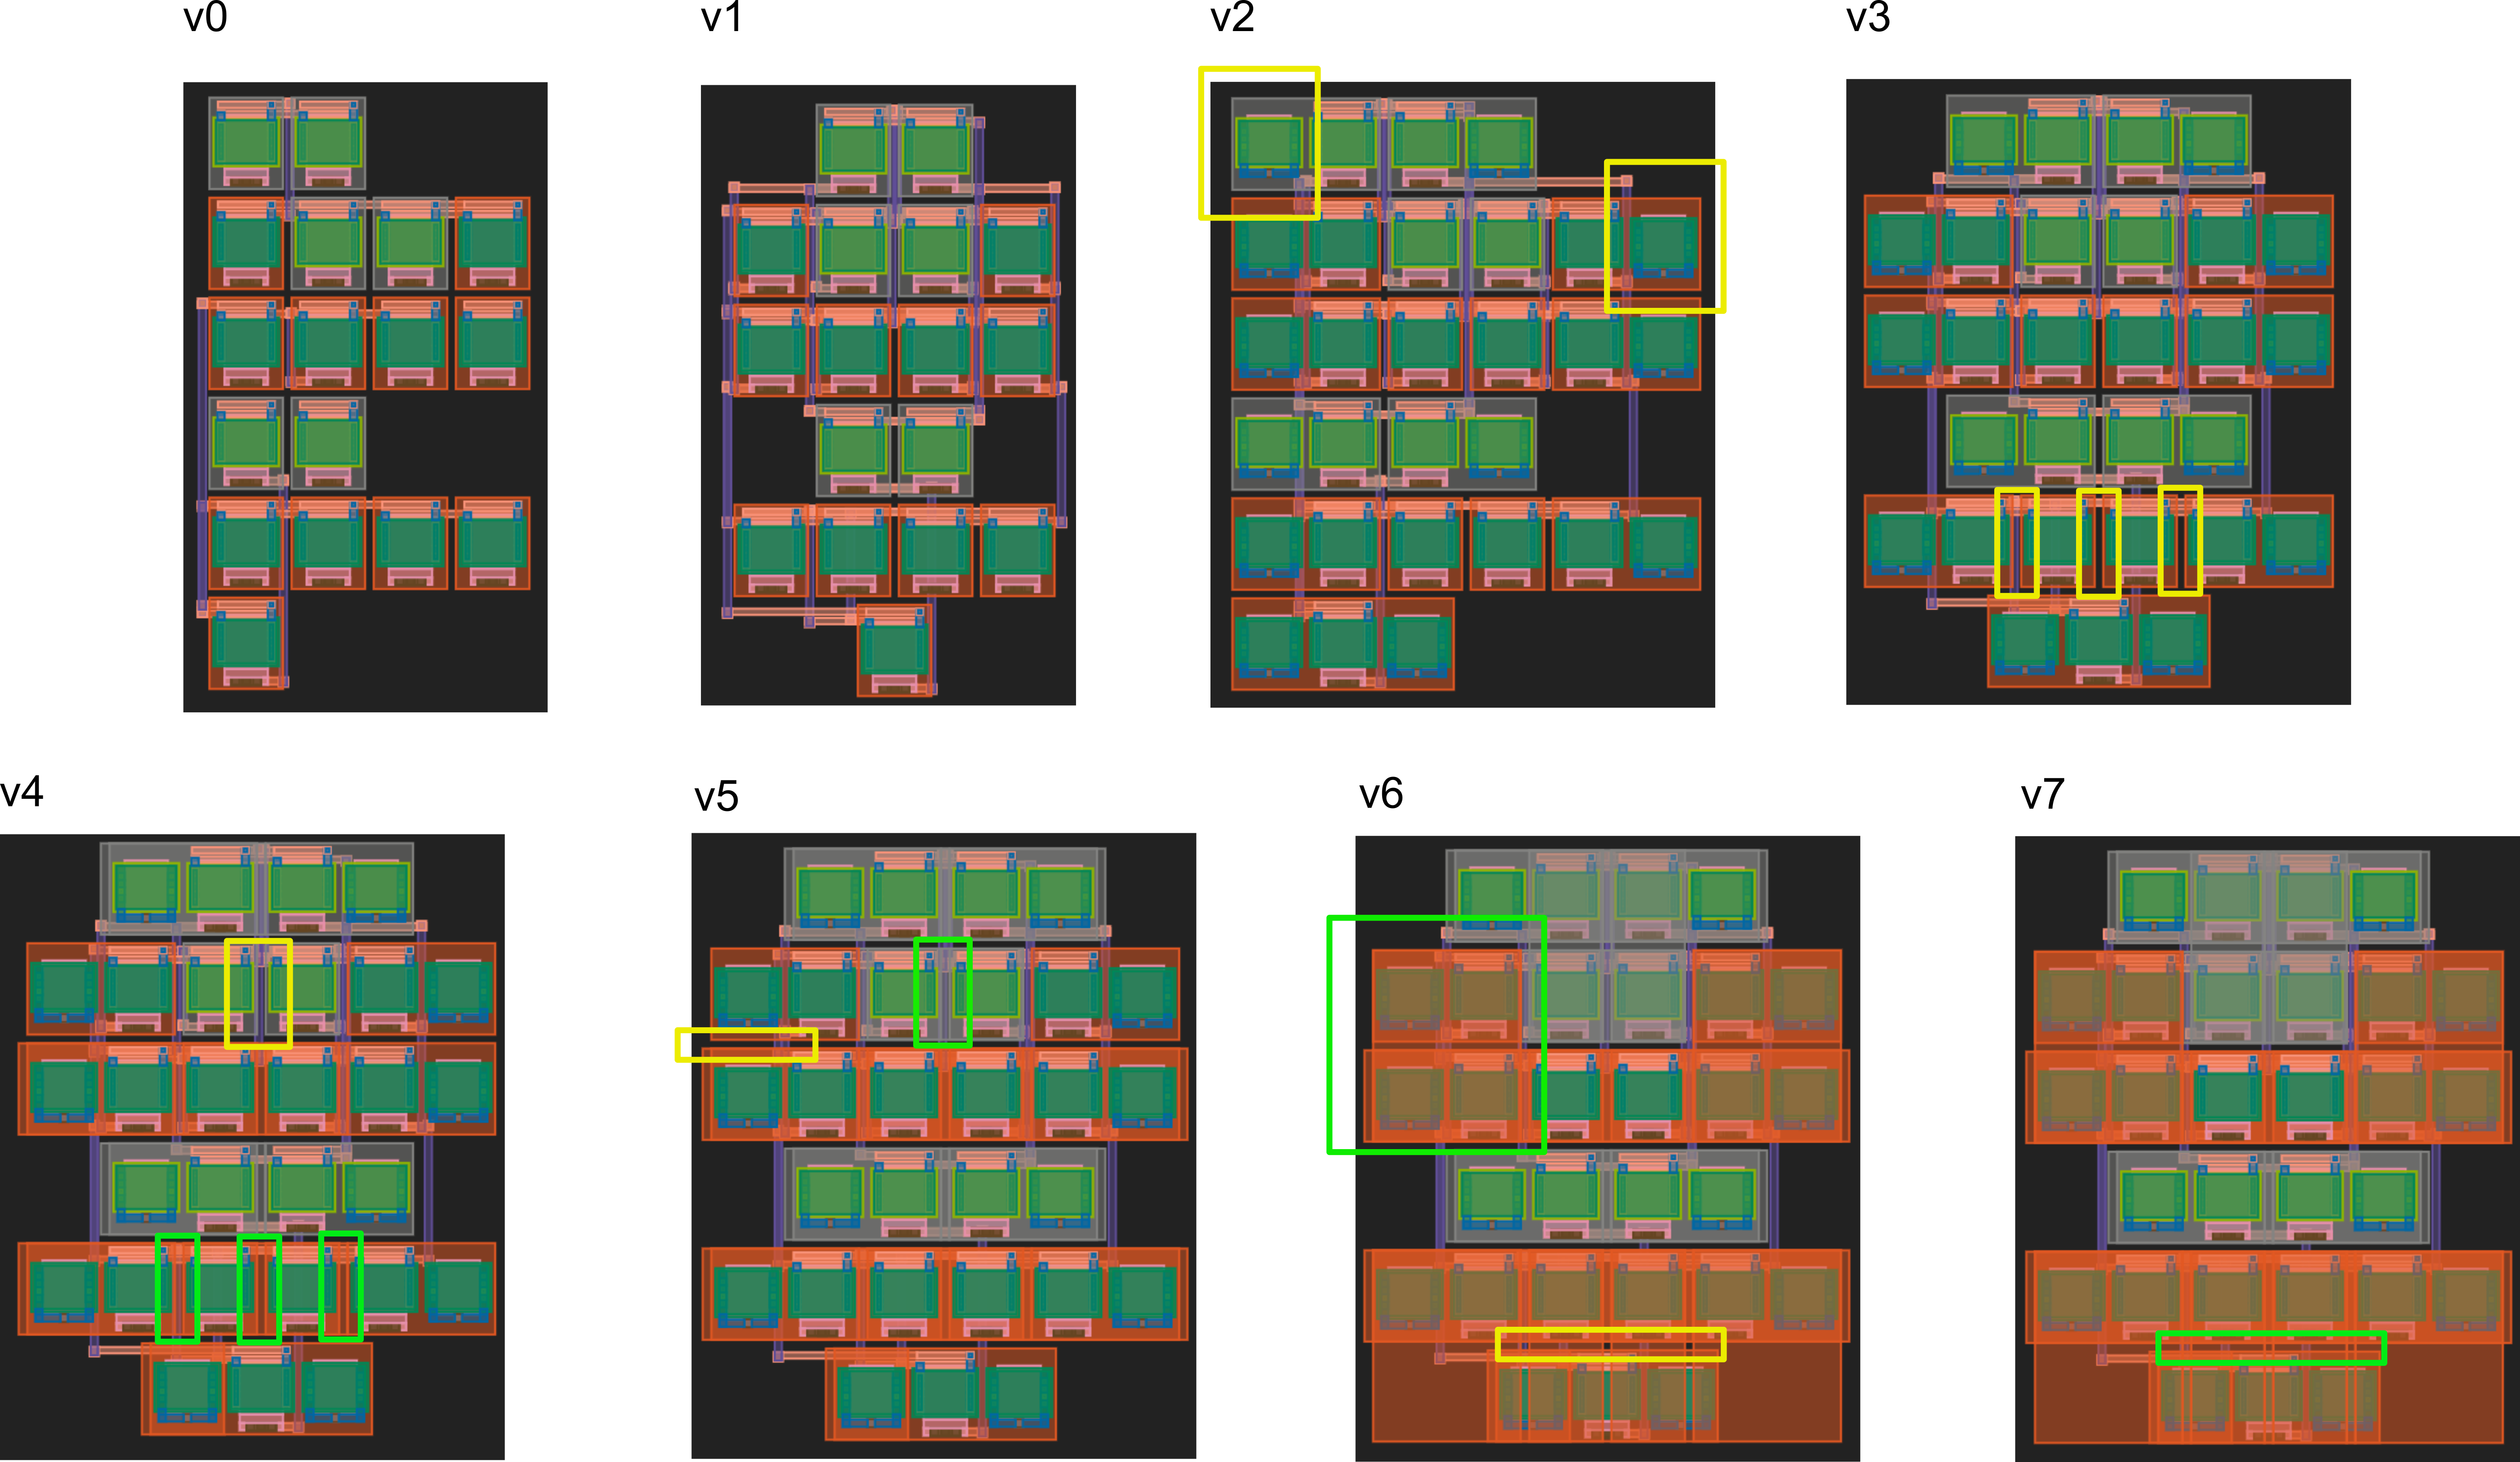

### Previous versions

In [194]:
#@title v.0

def create_layout(pdk: MappedPDK, width, length,sorted_positions, info_transistors,connections): # Function to create the overall layout
  all_layout = Component(name='final_layout') # Create a component to hold the entire layout
  results = {} # Initialize an empty dictionary to store intermediate results
  y_position = 0 # Initialize the y-coordinate for placing transistors
  for row in sorted_positions: # Iterate over each row of transistors
    print(row)
    x_position = 0 # Initialize the x-coordinate for placing transistors in the current row
    for transistor_name in row: # Iterate over each transistor in the current row
      print(transistor_name)
      key = f"{transistor_name}"
      type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] # Get the type of the current transistor
      results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name,with_dummy=False)
      results[f"{key}_ref"] = prec_ref_center(results[key])
      all_layout.add(results[f"{key}_ref"])
      movey(results[f"{key}_ref"], y_position) # Move the transistor to the correct y-coordinate
      movex(results[f"{key}_ref"], x_position) # Move the transistor to the correct x-coordinate

      x_position += results[key].size[0] + pdk.util_max_metal_seperation()# Update the x-coordinate for the next transistor in the row
    y_position += results[key].size[1] + pdk.util_max_metal_seperation() # Update the y-coordinate for the next row

  wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
  counter = 0
  for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
          for transistor in list(A.keys()):
              suffix = "_W" if counter % 2 == 0 else "_E"
              ports.append(results[f"{transistor}_ref"].ports[transistor + A[transistor] + suffix])  # You can choose the metal layer with layer=pdk.get_glayer("met2")
          counter += 1
          for i in range(0, len(ports), 5):
              group_ports = ports[i:i + 5]
              if len(group_ports) > 1:
                  all_layout.add(smart_route(pdk, *group_ports))

  return all_layout # Return the complete layout


In [175]:
#@title v.1
def create_layout(pdk: MappedPDK, width, length,sorted_positions, info_transistors,connections): # Function to create the overall layout
  all_layout = Component(name='final_layout') # Create a component to hold the entire layout
  results = {} # Initialize an empty dictionary to store intermediate results
    # Calculate total width and height of layout
  total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name,with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])
  total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0],with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

  # Initial y_position adjusted to center layout vertically
  y_position = (total_height - sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0],with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])) / 2

  for row in sorted_positions:
      # Initial x_position adjusted to center layout horizontally for each row
    x_position = (total_width - sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name,with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])) / 2
    for transistor_name in row: # Iterate over each transistor in the current row
      print(transistor_name)
      key = f"{transistor_name}"
      type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] # Get the type of the current transistor
      results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name,with_dummy=False)
      results[f"{key}_ref"] = prec_ref_center(results[key])
      all_layout.add(results[f"{key}_ref"])

      #RULES
      viam2m3 = via_stack(pdk,"met2","met3",centered=True)
      metal_min_dim = max(pdk.get_grule("met2")["min_width"],pdk.get_grule("met3")["min_width"])
      metal_space = max(pdk.get_grule("met2")["min_separation"],pdk.get_grule("met3")["min_separation"],metal_min_dim)
      gate_route_os = evaluate_bbox(viam2m3)[0]- results[key].ports[key+"multiplier_0_gate_W"].width + metal_space
      min_spacing_y = metal_space + 2*gate_route_os
      min_spacing_y = min_spacing_y - 2*abs(results[key].ports[key+"well_S"].center[1] - results[key].ports[key+"multiplier_0_gate_S"].center[1])


      movey(results[f"{key}_ref"], y_position) # Move the transistor to the correct y-coordinate
      movex(results[f"{key}_ref"], x_position) # Move the transistor to the correct x-coordinate
      x_position += results[key].size[0] + pdk.util_max_metal_seperation() # Update the x-coordinate for the next transistor in the row
    y_position += results[key].size[1] + pdk.util_max_metal_seperation() # Update the y-coordinate for the next row


  wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
  counter = 0
  for wire, A in wire_connections.items():
    ports = []
    if len(list(A.keys())) > 1:
      for transistor in list(A.keys()):
        suffix = "_W" if counter % 2 == 0 else "_E"
        """
        args:
        pdk = pdk to use
        edge1 = first port
        edge2 = second port
        vwidth = optional will default to vertical edge width if None
        hwidth = optional will default to horizontal edge width if None
        hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
        vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
        viaoffset = push the via away from both edges so that inside corner aligns with via corner
        ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
        fullbottom = fullbottom option for via
        """
        ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
      counter += 1
      #edges = alternate_edges(ports)
      for i in range(len(ports) - 1):
        all_layout.add(smart_route(pdk, ports[i],ports[i+1]))


  #estaria bé posar un substrate tap per transistors, si tenim dos pmos junts doncs fer-lo comu... etc

  return all_layout # Return the complete layout


In [179]:
#@title v.2
def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    # Function to create the overall layout
    all_layout = Component(name='final_layout')  # Create a component to hold the entire layout
    results = {}  # Initialize an empty dictionary to store intermediate results
    y_position = 0 # Initialize the y-coordinate for placing transistors
    # Initial y_position adjusted to center layout vertically

#····································································································································································

    for row in sorted_positions:
        x_position = 0
        prev_dim = 0
        for i, transistor_name in enumerate(row):  # Iterate over each transistor in the current row
            key = f"{transistor_name}"
            type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]  # Get the type of the current transistor
            with_dummy = (False, False)
            number_dummies = 0
            if len(row) == 1:  # Single transistor in row
                with_dummy = (True,True)
                number_dummies = 2
            elif i == 0:  # First transistor in row
                with_dummy = (True, False)
                number_dummies = 1
            elif i == len(row) - 1:  # Last transistor in row
                with_dummy = (False, True)
                number_dummies = 1
            # Create the transistor with the dummy settings
            results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
            results[f"{key}_ref"] = prec_ref_center(results[key])
            all_layout.add(results[f"{key}_ref"])

            # RULES
            viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
            metal_min_dim = max(pdk.get_grule("met2")["min_width"], pdk.get_grule("met3")["min_width"])
            metal_space = max(pdk.get_grule("met2")["min_separation"], pdk.get_grule("met3")["min_separation"], metal_min_dim)
            gate_route_os = evaluate_bbox(viam2m3)[0] - results[key].ports[key + "multiplier_0_gate_W"].width + metal_space
            min_spacing_y = metal_space + 2 * gate_route_os
            min_spacing_y = min_spacing_y - 2 * abs(results[key].ports[key + "well_S"].center[1] - results[key].ports[key + "multiplier_0_gate_S"].center[1])


            x_position += prev_dim + results[key].size[0]/2 + pdk.util_max_metal_seperation()
            prev_dim = results[key].size[0]/2

            movey(results[f"{key}_ref"], y_position)  # Move the transistor to the correct y-coordinate
            movex(results[f"{key}_ref"], x_position)  # Move the transistor to the correct x-coordinate

            #TO DO THE UPDATE WE MUST TAKE INTO CONSIDERATION THE ACTUAL AND NEXT ELEMENT
            #x_position += results[key].size[0] + pdk.util_max_metal_seperation() # Update the x-coordinate for the next transistor in the row
        y_position += results[key].size[1] + pdk.util_max_metal_seperation()  # Update the y-coordinate for the next row

#····································································································································································

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))

#····································································································································································

    return all_layout  # Return the complete layout


In [181]:
#@title v.3

def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    # Function to create the overall layout
    all_layout = Component(name='final_layout')  # Create a component to hold the entire layout
    results = {}  # Initialize an empty dictionary to store intermediate results
    y_position = 0 # Initialize the y-coordinate for placing transistors
    # Initial y_position adjusted to center layout vertically
    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name,with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])
    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0],with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

#····································································································································································

    for row in sorted_positions:
        #x_position = 0
        prev_dim = 0
      # Initial x_position adjusted to center layout horizontally for each row
        x_position = (total_width - sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name,with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])) / 2

        for i, transistor_name in enumerate(row):  # Iterate over each transistor in the current row
            key = f"{transistor_name}"
            type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]  # Get the type of the current transistor
            with_dummy = (False, False)
            number_dummies = 0
            if len(row) == 1:  # Single transistor in row
                with_dummy = (True,True)
                number_dummies = 2
            elif i == 0:  # First transistor in row
                with_dummy = (True, False)
                number_dummies = 1
            elif i == len(row) - 1:  # Last transistor in row
                with_dummy = (False, True)
                number_dummies = 1
            # Create the transistor with the dummy settings
            results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
            results[f"{key}_ref"] = prec_ref_center(results[key])
            all_layout.add(results[f"{key}_ref"])

            # RULES
            viam2m3 = via_stack(pdk, "met2", "met3", centered=True)
            metal_min_dim = max(pdk.get_grule("met2")["min_width"], pdk.get_grule("met3")["min_width"])
            metal_space = max(pdk.get_grule("met2")["min_separation"], pdk.get_grule("met3")["min_separation"], metal_min_dim)
            gate_route_os = evaluate_bbox(viam2m3)[0] - results[key].ports[key + "multiplier_0_gate_W"].width + metal_space
            min_spacing_y = metal_space + 2 * gate_route_os
            min_spacing_y = min_spacing_y - 2 * abs(results[key].ports[key + "well_S"].center[1] - results[key].ports[key + "multiplier_0_gate_S"].center[1])


            x_position += prev_dim + results[key].size[0]/2 + pdk.util_max_metal_seperation()
            prev_dim = results[key].size[0]/2

            movey(results[f"{key}_ref"], y_position)  # Move the transistor to the correct y-coordinate
            movex(results[f"{key}_ref"], x_position)  # Move the transistor to the correct x-coordinate

            #TO DO THE UPDATE WE MUST TAKE INTO CONSIDERATION THE ACTUAL AND NEXT ELEMENT
            #x_position += results[key].size[0] + pdk.util_max_metal_seperation() # Update the x-coordinate for the next transistor in the row
        y_position += results[key].size[1] + pdk.util_max_metal_seperation()  # Update the y-coordinate for the next row

#····································································································································································

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))

#····································································································································································

    return all_layout  # Return the complete layout


In [185]:
#@title v.4

def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    all_layout = Component(name='final_layout')
    results = {}
    y_position = 0
    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])
    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0], with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

    for row in sorted_positions:
        row_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])
        x_position = (total_width - row_width) / 2
        x_position_init = (total_width - row_width) / 2
        prev_dim = 0

         # Check if all transistors in the row are the same type
        row_types = [info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] for transistor_name in row]
        if all(t == row_types[0] for t in row_types):
            # Get coordinates to create a rectangle
            row_height = PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=False).size[1]  #ens es indiferent si hi han dummies o no
            rectangle_dimensions = (row_width, row_height)
            if row_types[0] == "pmos":
                rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
            elif row_types[0] == "nmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
            rectangle_ref = all_layout << rectangle
            #all_layout.add(rectangle)
            movey(rectangle_ref, y_position-row_height/2)  # Adjust y_position to place rectangle below transistors
            movex(rectangle_ref, x_position_init)  # Adjust y_position to place rectangle below transistors

        for i, transistor_name in enumerate(row):
            key = f"{transistor_name}"
            type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]
            with_dummy = (False, False)
            if len(row) == 1:
                with_dummy = (True, True)
            elif i == 0:
                with_dummy = (True, False)
            elif i == len(row) - 1:
                with_dummy = (False, True)

            results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
            results[f"{key}_ref"] = prec_ref_center(results[key])
            all_layout.add(results[f"{key}_ref"])

            x_position += prev_dim + results[key].size[0] / 2 + pdk.util_max_metal_seperation()
            prev_dim = results[key].size[0] / 2
            movey(results[f"{key}_ref"], y_position)
            movex(results[f"{key}_ref"], x_position)

        y_position += results[key].size[1] + pdk.util_max_metal_seperation()

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))

    return all_layout

def makeRectangle(pdk: MappedPDK, dimensions, layer):
    met1 = pdk.get_glayer(str(layer))
    top_level = Component(name="metal_track")
    top_level << rectangle(size=(dimensions[0], dimensions[1]), layer=met1)
    return top_level


In [187]:
#@title v.5

def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    all_layout = Component(name='final_layout')
    results = {}
    y_position = 0
    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])
    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0], with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

    for row in sorted_positions:
        row_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])
        x_position = (total_width - row_width) / 2
        prev_dim = 0

        row_types = [info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] for transistor_name in row]

        # Check if all transistors in the row are the same type
        if all(t == row_types[0] for t in row_types):
            # Get coordinates to create a rectangle
            row_height = PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=False).size[1]
            rectangle_dimensions = (row_width, row_height)
            if row_types[0] == "pmos":
                rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
            elif row_types[0] == "nmos":
                rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
            rectangle_ref = all_layout << rectangle
            movey(rectangle_ref, y_position - row_height / 2)
            movex(rectangle_ref, x_position)

        # Handle groups of consecutive same-type transistors
        i = 0
        while i < len(row):
            start_index = i
            current_type = row_types[i]
            while i + 1 < len(row) and row_types[i + 1] == current_type:
                i += 1
            if i > start_index:  # Two or more consecutive transistors of the same type
                group_width = sum([PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index, i + 1)])
                group_height = PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[start_index], with_dummy=False).size[1]
                rectangle_dimensions = (group_width, group_height)
                if current_type == "pmos":
                    rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
                elif current_type == "nmos":
                    rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
                rectangle_ref = all_layout << rectangle
                movey(rectangle_ref, y_position - group_height / 2)
                movex(rectangle_ref, x_position + PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=(True,False)).size[0] + pdk.util_max_metal_seperation() + sum([PlaceTransistor(pdk, type=row_types[j], width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index-1)]) / 2)
            i += 1

        for i, transistor_name in enumerate(row):
            key = f"{transistor_name}"
            type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]
            with_dummy = (False, False)
            if len(row) == 1:
                with_dummy = (True, True)
            elif i == 0:
                with_dummy = (True, False)
            elif i == len(row) - 1:
                with_dummy = (False, True)

            results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
            results[f"{key}_ref"] = prec_ref_center(results[key])
            all_layout.add(results[f"{key}_ref"])

            x_position += prev_dim + results[key].size[0] / 2 + pdk.util_max_metal_seperation()
            prev_dim = results[key].size[0] / 2
            movey(results[f"{key}_ref"], y_position)
            movex(results[f"{key}_ref"], x_position)

        y_position += results[key].size[1] + pdk.util_max_metal_seperation()

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))

    return all_layout

def makeRectangle(pdk: MappedPDK, dimensions, layer):
    met1 = pdk.get_glayer(str(layer))
    top_level = Component(name="metal_track")
    top_level << rectangle(size=(dimensions[0], dimensions[1]), layer=met1)
    return top_level


In [189]:
#@title v.6
def create_layout(pdk: MappedPDK, width, length, sorted_positions, info_transistors, connections):
    all_layout = Component(name='final_layout')
    results = {}
    y_position = 0
    transistor_positions = {}

    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])

    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0], with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

    #------------------------------ITERATE OVER ROWS OF TRANSISTORS---------------------------------------
    for row_index, row in enumerate(sorted_positions):
      row_types = [info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] for transistor_name in row] #types of transistors in the row
      row_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])
      x_position = (total_width - row_width) / 2
      prev_dim = 0

      # Check if all transistors in the row are the same type
      if all(t == row_types[0] for t in row_types):
          # Get coordinates to create a rectangle
          row_height = PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=False).size[1]
          rectangle_dimensions = (row_width, row_height)
          if row_types[0] == "pmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
          elif row_types[0] == "nmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
          rectangle_ref = all_layout << rectangle
          movey(rectangle_ref, y_position - row_height / 2)
          movex(rectangle_ref, x_position)

        # Handle groups of consecutive same-type transistors
      i = 0
      while i < len(row):
          start_index = i
          current_type = row_types[i]
          while i + 1 < len(row) and row_types[i + 1] == current_type:
              i += 1
          if i > start_index:  # Two or more consecutive transistors of the same type
              group_width = sum([PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index, i + 1)])
              group_height = PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[start_index], with_dummy=False).size[1]
              rectangle_dimensions = (group_width, group_height)
              if current_type == "pmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
              elif current_type == "nmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
              rectangle_ref = all_layout << rectangle
              movey(rectangle_ref, y_position - group_height / 2)
              movex(rectangle_ref, x_position + PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=(True,False)).size[0] + pdk.util_max_metal_seperation() + sum([PlaceTransistor(pdk, type=row_types[j], width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index-1)]) / 2)
          i += 1

      for i, transistor_name in enumerate(row):
          key = f"{transistor_name}"
          type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]
          with_dummy = (False, False)
          if len(row) == 1:
              with_dummy = (True, True)
          elif i == 0:
              with_dummy = (True, False)
          elif i == len(row) - 1:
              with_dummy = (False, True)

          results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
          results[f"{key}_ref"] = prec_ref_center(results[key])
          all_layout.add(results[f"{key}_ref"])

          x_position += prev_dim + results[key].size[0] / 2 + pdk.util_max_metal_seperation()
          prev_dim = results[key].size[0] / 2
          movey(results[f"{key}_ref"], y_position)
          movex(results[f"{key}_ref"], x_position)

          # Store position and type of each transistor
          if row_index not in transistor_positions:
              transistor_positions[row_index] = []
          transistor_positions[row_index].append({
                  'name': transistor_name,
                  'type': type_trt,
                  'x_position': x_position,
                  'y_position': y_position,
                  'width': results[key].size[0],
                  'height': results[key].size[1]
              })

      y_position += results[key].size[1] + pdk.util_max_metal_seperation()

    for row_index, row_transistors in transistor_positions.items():
        if row_index >= 1:  # Start from the third row
            for t in row_transistors:
                if t['type'] in ['pmos', 'nmos']:
                    # Check for matching transistor directly above in the immediate previous row
                    for above_t in transistor_positions.get(row_index - 1, []):
                        if above_t['type'] == t['type']:
                          t_left = t['x_position']-t['width']/2
                          t_right = t['x_position'] + t['width']/2
                          above_t_left = above_t['x_position']-above_t['width']/2
                          above_t_right = above_t['x_position'] + above_t['width']/2
                          if np.any(np.isclose(round(t_left,2), np.arange(above_t_left, above_t_right,0.001))) or np.any(np.isclose(round(t_right,2), np.arange(above_t_left, above_t_right,0.001))) or np.any(np.isclose(round(above_t_left,2), np.arange(t_left, t_right,0.001))) or np.any(np.isclose(round(above_t_right,2), np.arange(t_left, t_right,0.001))):
                              # They share some range in the x-axis
                              smallest_width = min(t['width'], above_t['width'])
                              smallest_height = min(t['height'], above_t['height'])
                              dimensions = (smallest_width, abs(above_t['y_position'] - t['y_position']) + t['height'])
                              right_x_position = max((t['x_position'], above_t['x_position']))-smallest_width/2
                              lowest_y_position = min(t['y_position'], above_t['y_position'])-smallest_height/2
                              if t['type'] == 'pmos':
                                  rect = makeRectangle(pdk, dimensions, 'nwell')
                              elif t['type'] == 'nmos':
                                  rect = makeRectangle(pdk, dimensions, 'pwell')
                              rectangle_ref = all_layout << rect
                              if t['width'] < above_t['width']:
                                  movex(rectangle_ref, t['x_position']-t['width']/2)
                              else:
                                  movex(rectangle_ref,above_t['x_position']-above_t['width']/2)
                              movey(rectangle_ref, lowest_y_position)
                              break

    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))
    return all_layout

def makeRectangle(pdk: MappedPDK, dimensions, layer):
    met1 = pdk.get_glayer(str(layer))
    top_level = Component(name="metal_track")
    top_level << rectangle(size=(dimensions[0], dimensions[1]), layer=met1)
    return top_level


### Final version

In [191]:
#@title v.8
    all_layout = Component(name='final_layout')
    results = {}
    pre_results = {}
    y_position = 0
    transistor_positions = {}

    total_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for row in sorted_positions for transistor_name in row])

    total_height = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == row[0], 'Type'].iloc[0], width=width, length=length, portName=row[0], with_dummy=False).size[1] + pdk.util_max_metal_seperation() for row in sorted_positions])

    #------------------------------ITERATE OVER ROWS OF TRANSISTORS---------------------------------------
    for row_index, row in enumerate(sorted_positions):
      row_types = [info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0] for transistor_name in row] #types of transistors in the row
      row_width = sum([PlaceTransistor(pdk, type=info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0], width=width, length=length, portName=transistor_name, with_dummy=False).size[0] + pdk.util_max_metal_seperation() for transistor_name in row])
      x_position = (total_width - row_width) / 2
      prev_dim = 0

      # Check if all transistors in the row are the same type
      if all(t == row_types[0] for t in row_types):
          # Get coordinates to create a rectangle
          row_height = PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=False).size[1]
          rectangle_dimensions = (row_width, row_height)
          if row_types[0] == "pmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
          elif row_types[0] == "nmos":
              rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
          rectangle_ref = all_layout << rectangle
          movey(rectangle_ref, y_position - row_height / 2)
          movex(rectangle_ref, x_position)

        # Handle groups of consecutive same-type transistors
      i = 0
      while i < len(row):
          start_index = i
          current_type = row_types[i]
          while i + 1 < len(row) and row_types[i + 1] == current_type:
              i += 1
          if i > start_index:  # Two or more consecutive transistors of the same type
              group_width = sum([PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index, i + 1)])
              group_height = PlaceTransistor(pdk, type=current_type, width=width, length=length, portName=row[start_index], with_dummy=False).size[1]
              rectangle_dimensions = (group_width, group_height)
              if current_type == "pmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'nwell')
              elif current_type == "nmos":
                  rectangle = makeRectangle(pdk, rectangle_dimensions, 'pwell')
              rectangle_ref = all_layout << rectangle
              movey(rectangle_ref, y_position - group_height / 2)
              movex(rectangle_ref, x_position + PlaceTransistor(pdk, type=row_types[0], width=width, length=length, portName=row[0], with_dummy=(True,False)).size[0] + pdk.util_max_metal_seperation() + sum([PlaceTransistor(pdk, type=row_types[j], width=width, length=length, portName=row[j], with_dummy=False).size[0] + pdk.util_max_metal_seperation() for j in range(start_index-1)]) / 2)
          i += 1

      for i, transistor_name in enumerate(row):
          print("Transistor name: ",transistor_name)
          key = f"{transistor_name}"
          type_trt = info_transistors.loc[info_transistors['Name'] == transistor_name, 'Type'].iloc[0]
          with_dummy = (False, False)
          if len(row) == 1:
              with_dummy = (True, True)
          elif i == 0:
              with_dummy = (True, False)
          elif i == len(row) - 1:
              with_dummy = (False, True)

          pre_results[key] = PlaceTransistor(pdk, type=type_trt, width=width, length=length, portName=transistor_name, with_dummy=with_dummy)
          results[f"{key}_ref"] = prec_ref_center(pre_results[key])
          all_layout.add(results[f"{key}_ref"])

          x_position += prev_dim + pre_results[key].size[0] / 2 + pdk.util_max_metal_seperation()
          prev_dim = pre_results[key].size[0] / 2
          movey(results[f"{key}_ref"], y_position)
          movex(results[f"{key}_ref"], x_position)

          # Store position and type of each transistor
          if row_index not in transistor_positions:
              transistor_positions[row_index] = []
          transistor_positions[row_index].append({
                  'name': transistor_name,
                  'type': type_trt,
                  'x_position': x_position,
                  'y_position': y_position,
                  'width': pre_results[key].size[0],
                  'height': pre_results[key].size[1]
              })

      y_position += pre_results[key].size[1] + pdk.util_max_metal_seperation()

    rect_positions = {'pmos': [], 'nmos': []}

    for row_index, row_transistors in transistor_positions.items():
        if row_index >= 1:
            for t in row_transistors:
                if t['type'] in ['pmos', 'nmos']:
                    for above_t in transistor_positions.get(row_index - 1, []):
                        if above_t['type'] == t['type']:
                            t_left = t['x_position'] - t['width'] / 2
                            t_right = t['x_position'] + t['width'] / 2
                            above_t_left = above_t['x_position'] - above_t['width'] / 2
                            above_t_right = above_t['x_position'] + above_t['width'] / 2
                            if np.any(np.isclose(round(t_left, 2), np.arange(above_t_left, above_t_right, 0.001))) or \
                              np.any(np.isclose(round(t_right, 2), np.arange(above_t_left, above_t_right, 0.001))) or \
                              np.any(np.isclose(round(above_t_left, 2), np.arange(t_left, t_right, 0.001))) or \
                              np.any(np.isclose(round(above_t_right, 2), np.arange(t_left, t_right, 0.001))):
                                smallest_width = min(t['width'], above_t['width'])
                                smallest_height = min(t['height'], above_t['height'])
                                dimensions = (smallest_width, abs(above_t['y_position'] - t['y_position']) + t['height'])
                                right_x_position = max((t['x_position'], above_t['x_position'])) - smallest_width / 2
                                lowest_y_position = min(t['y_position'], above_t['y_position']) - smallest_height / 2
                                if t['type'] == 'pmos':
                                    rect = makeRectangle(pdk, dimensions, 'nwell')
                                    rect_positions['pmos'].append({
                                        'x_position': t['x_position'],
                                        'y_position': lowest_y_position,
                                        'width': t['width'],
                                        'height': dimensions[1]
                                    })
                                elif t['type'] == 'nmos':
                                    rect = makeRectangle(pdk, dimensions, 'pwell')
                                    rect_positions['nmos'].append({
                                        'x_position': t['x_position'],
                                        'y_position': lowest_y_position,
                                        'width': t['width'],
                                        'height': dimensions[1]
                                    })
                                rectangle_ref = all_layout << rect
                                if t['width'] < above_t['width']:
                                    movex(rectangle_ref, t['x_position'] - t['width'] / 2)
                                else:
                                    movex(rectangle_ref, above_t['x_position'] - above_t['width'] / 2)
                                movey(rectangle_ref, lowest_y_position)
                                break


    wire_connections = find_wire_connections(G.to_undirected(), 'wire', 'transistor')
    counter = 0
    for wire, A in wire_connections.items():
      ports = []
      if len(list(A.keys())) > 1:
        for transistor in list(A.keys()):
          suffix = "_W" if counter % 2 == 0 else "_E"
          """
          args:
          pdk = pdk to use
          edge1 = first port
          edge2 = second port
          vwidth = optional will default to vertical edge width if None
          hwidth = optional will default to horizontal edge width if None
          hglayer = glayer for vertical route. Defaults to the layer of the edge oriented N/S
          vglayer = glayer for horizontal route. Defaults to the layer of the edge oriented E/W
          viaoffset = push the via away from both edges so that inside corner aligns with via corner
          ****via offset can also be specfied as a tuple(bool,bool): movex? if viaoffset[0] and movey? if viaoffset[1]
          fullbottom = fullbottom option for via
          """
          print(results)
          ports.append(results[f"{transistor}_ref"].ports[transistor+A[transistor]+suffix]) #es pot escolllir la capa del metall que posem layer=pdk.get_glayer("met2")
        counter += 1
        #edges = alternate_edges(ports)
        for i in range(len(ports) - 1):
          all_layout.add(smart_route(pdk, ports[i],ports[i+1]))


    # Call the function to fill gaps between transistors
    fill_gap_between_rectangles(pdk, all_layout, rect_positions)

    return all_layout


def makeRectangle(pdk: MappedPDK, dimensions, layer):
    met1 = pdk.get_glayer(str(layer))
    top_level = Component(name="metal_track")
    top_level << rectangle(size=(dimensions[0], dimensions[1]), layer=met1)
    return top_level

def fill_gap_between_rectangles(pdk, all_layout, rect_positions):
    for rect_type, rects in rect_positions.items():
        for i in range(len(rects) - 1):
            current_rect = rects[i]
            next_rect = rects[i + 1]
            if (next_rect['x_position'] - next_rect['width'] / 2) -(current_rect['x_position'] + current_rect['width'] / 2) < 1.5 and (next_rect['x_position'] - next_rect['width'] / 2) -(current_rect['x_position'] + current_rect['width'] / 2) > 0:
                fill_width = next_rect['x_position'] - next_rect['width'] / 2 - (current_rect['x_position'] + current_rect['width'] / 2)
                fill_height = max(current_rect['height'], next_rect['height'])
                fill_x_position = (current_rect['x_position'] + current_rect['width'] / 2 + next_rect['x_position'] - next_rect['width'] / 2) / 2
                fill_y_position = current_rect['y_position']

                if rect_type == 'pmos':
                    fill_rect = makeRectangle(pdk, (fill_width, fill_height), 'nwell')
                elif rect_type == 'nmos':
                    fill_rect = makeRectangle(pdk, (fill_width, fill_height), 'pwell')

                rect_ref = all_layout << fill_rect
                movey(rect_ref, fill_y_position)
                movex(rect_ref, fill_x_position - fill_width / 2)


C {nmos.sym} 80 100 2 0 {name=M2 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {nmos.sym} 0 200 2 0 {name=M4 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {nmos.sym} -140 100 2 1 {name=M5 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {gnd.sym} -20 260 0 0 {name=l1 lab=GND}
C {nmos.sym} -260 100 2 1 {name=M1 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {nmos.sym} 200 100 2 0 {name=M3 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {nmos.sym} -220 -150 2 1 {name=M6 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {nmos.sym} -90 -150 2 0 {name=M7 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {nmos.sym} 30 -150 2 1 {name=M8 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {nmos.sym} 160 -150 2 0 {name=M9 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {nmos.sym} -220 -260 2 1 {name=M10 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {nmos.sym} 160 -260 2 0 {name=M11 model=M2N7002 device=2N7002 footprint=SOT23 m=1}
C {pmos.sym} 30 -260 0 0 {name=M12 mo

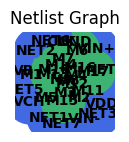

['M4']
M4
['M1', 'M5', 'M2', 'M3']
M1
M5
M2
M3
['M16', 'M17']
M16
M17
['M6', 'M7', 'M8', 'M9']
M6
M7
M8
M9
['M10', 'M14', 'M12', 'M11']
M10
M14
M12
M11
['M13', 'M15']
M13
M15


<ipython-input-201-d2641420df44>:11: UserWarning: Unnamed cells, 17 in 'final_layout$35'
  Componente.write_gds('Component.gds')
2024-11-15 11:27:04.918 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'Component.gds'


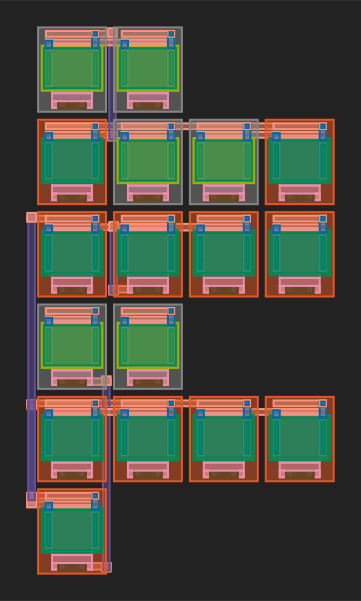

In [201]:
#_________USER INPUT_________________________
circuit_name = "Miyahara"
#_________PROGRAM____________________________
sch_file_name = '/content/'+str(circuit_name)+'.sch'
netlist_file_name = '/content/'+str(circuit_name)+'.spice'
df_SpacePosition = parse_transistor_file(sch_file_name, sort_by='Y')
sorted = sort_positions(df_SpacePosition)
netlist = extract_transistor_data_from_file(netlist_file_name)
G = create_grapho(netlist,k_value=1, fig_size=(1,1))
Componente = create_layout(sky130_mapped_pdk,width=2,length=2,sorted_positions=sorted,info_transistors=df_SpacePosition,connections=0)
Componente.write_gds('Component.gds')
display_gds('Component.gds',scale=2)

In [ ]:
from google.colab import files
files.download('Component.gds')

#### DRC check! :)

In [196]:
!klayout Component.gds -zz -r glayout/flow/pdk/sky130_mapped/sky130.lydrc
!echo -e "\n$(grep -c "<value>" sky130_drc.txt) DRC Errors Found"

"input" in: sky130.lydrc:71
    Polygons (raw): 29 (flat)  29 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:72
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.010s  Memory: 188.00M
"polygons" in: sky130.lydrc:73
    Polygons (raw): 14 (flat)  14 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:74
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:75
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:76
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:77
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:78
    Polygons (raw): 0 (flat)  0 (hierarchical)
    Elapsed: 0.000s  Memory: 188.00M
"polygons" in: sky130.lydrc:79
    Polygons (raw): 0 (flat)  0 (hierarchical)
 

# Improvements to be done:


1.   Adding transistor bulk
2.   Creating pin names
3.   Connecting dummy transistors to VDD
4.   DRC check
5.   LVS check
6.   Optimizing placing

